# Imports
xlrd - read excel  
pandas - useful for data manipulation and its dataframes  
os, sys - useful for file navigation  
numpy - useful for matrices  
math - constants and basic functions  

In [1]:
import xlrd
import pandas as pd
import os, sys
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statistics
import plotly.express as px
import kmeans1d
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate

# Process Files and Data

In [2]:
def mult_quat(q1, q2):
    w = q1[0]*q2[0] - np.dot(q1[1], q2[1])
    v = np.add(np.cross(q1[1], q2[1]), q1[0]*q2[1])
    v = np.add(v, q2[0]*q1[1])
    return (w, v)
               
def conj_quat(quat):
    return (quat[0], -1*quat[1])

def inv_quat(quat):
    conjugate = conj_quat(quat)
    norm = math.sqrt(quat[0]**2 + quat[1][0]**2 + quat[1][1]**2 + quat[1][2]**2)
    return (conjugate[0] / norm, conjugate[1] / norm)

def rotate_quat(vect, rot_vect):
    rot_vect_conj = inv_quat(rot_vect)
    rotated_vect = mult_quat(rot_vect, vect)
    rotated_vect = mult_quat(rotated_vect, rot_vect_conj)
    return rotated_vect

def knee_angle_deg(thigh_quat, shank_quat):
    conjugate_thigh = conj_quat(thigh_quat)
    relative_quat = mult_quat(conjugate_thigh, shank_quat)
    knee_angle_w = math.acos(relative_quat[0])*360/math.pi
    return knee_angle_w  # is it possible to extract sin component from unit vector and then average angle from that?
    

In [3]:
def process_file(filepath):
    print(filepath)
    wb = xlrd.open_workbook(filepath)  # Open workbook
    
    subj_data = wb.sheet_by_index(1)  # Open Sheet2 which contains subject data
    height = subj_data.cell_value(0, 1)
    floor_to_shank_imu = subj_data.cell_value(1, 1)
    floor_to_knee = subj_data.cell_value(2, 1)
    floor_to_hip = subj_data.cell_value(3, 1)
    knee_to_hip_imu = subj_data.cell_value(4, 1)
    weight = subj_data.cell_value(5, 1)
    gender = subj_data.cell_value(6, 1)
    angle_offset1 = subj_data.cell_value(7, 1)
    angle_offset2 = subj_data.cell_value(8, 1)
    
    imu_data = wb.sheet_by_index(0)  # Open Sheet1 which contains IMU Data
    num_data_points = imu_data.nrows
    compiled_data = {'Time': imu_data.col_values(1),
                     'Time Between Readings': imu_data.col_values(2),
                     'Angle': imu_data.col_values(5),
                     'Thigh X Gravity Vector': [x * -1 for x in imu_data.col_values(7)], 
                     'Thigh Y Gravity Vector': [x * -1 for x in imu_data.col_values(8)], 
                     'Thigh Z Gravity Vector': imu_data.col_values(9),
                     'Thigh X Gyroscope Vector': [x * -1 for x in imu_data.col_values(11)],
                     'Thigh Y Gyroscope Vector': [x * -1 for x in imu_data.col_values(12)],
                     'Thigh Z Gyroscope Vector': imu_data.col_values(13),
                     'Thigh X Magnetometer Vector': [x * -1 for x in imu_data.col_values(15)],
                     'Thigh Y Magnetometer Vector': [x * -1 for x in imu_data.col_values(16)],
                     'Thigh Z Magnetometer Vector': imu_data.col_values(17),
                     'Thigh X Euler Vector': [x * -1 for x in imu_data.col_values(19)],
                     'Thigh Y Euler Vector': [x * -1 for x in imu_data.col_values(20)],
                     'Thigh Z Euler Vector': imu_data.col_values(21),
                     'Thigh X Acceleration Vector': [x * -1 for x in imu_data.col_values(23)],
                     'Thigh Y Acceleration Vector': [x * -1 for x in imu_data.col_values(24)],
                     'Thigh Z Acceleration Vector': imu_data.col_values(25),
                     'Thigh X Linear Acceleration Vector': [x * -1 for x in imu_data.col_values(27)],
                     'Thigh Y Linear Acceleration Vector': [x * -1 for x in imu_data.col_values(28)],
                     'Thigh Z Linear Acceleration Vector': imu_data.col_values(29),
                     'Thigh W Quaternion': imu_data.col_values(31),
                     'Thigh X Quaternion': imu_data.col_values(32),
                     'Thigh Y Quaternion': imu_data.col_values(33),
                     'Thigh Z Quaternion': imu_data.col_values(34),
                     'Weight': [weight] * num_data_points,
                     'Height': [height] * num_data_points,
                     'Floor to Shank IMU': [floor_to_shank_imu] * num_data_points,
                     'Floor to Knee': [floor_to_knee] * num_data_points,
                     'Floor to Hip': [floor_to_hip] * num_data_points,
                     'Knee to Hip IMU': [knee_to_hip_imu] * num_data_points,
                     'Gender': [gender] * num_data_points,
                     'Angle_Offset_1': [angle_offset1] * num_data_points,
                     'Angle_Offset_2': [angle_offset2] * num_data_points,
                    }
    thigh_x_ang_acc = []
    thigh_y_ang_acc = []
    thigh_z_ang_acc = []
    thigh_grav_acc_cum = []
#     thigh_roll = []
#     thigh_pitch = []
#     thigh_yaw = []
    for i in range(1, num_data_points):
        thigh_x_ang_acc.append((compiled_data['Thigh X Gyroscope Vector'][i] - compiled_data['Thigh X Gyroscope Vector'][i-1])/compiled_data['Time Between Readings'][i])
        thigh_y_ang_acc.append((compiled_data['Thigh Y Gyroscope Vector'][i] - compiled_data['Thigh Y Gyroscope Vector'][i-1])/compiled_data['Time Between Readings'][i])
        thigh_z_ang_acc.append((compiled_data['Thigh Z Gyroscope Vector'][i] - compiled_data['Thigh Z Gyroscope Vector'][i-1])/compiled_data['Time Between Readings'][i])
        thigh_grav_acc_cum.append(sqrt(abs(compiled_data['Thigh X Gravity Vector'][i]**2) + abs(compiled_data['Thigh Y Gravity Vector'][i]**2) + abs(compiled_data['Thigh Z Gravity Vector'][i]**2)))
#         thigh_roll_temp = 180 / math.pi * math.atan(compiled_data['Thigh X Gravity Vector'][i] / sqrt(abs(compiled_data['Thigh Z Gravity Vector'][i]**2) + abs(compiled_data['Thigh Y Gravity Vector'][i]**2)))
#         thigh_roll.append(thigh_roll_temp)
#         thigh_pitch_temp = 180 / math.pi * math.atan(compiled_data['Thigh Z Gravity Vector'][i] / sqrt(abs(compiled_data['Thigh X Gravity Vector'][i]**2) + abs(compiled_data['Thigh Y Gravity Vector'][i]**2)))
#         thigh_pitch.append(thigh_pitch_temp)
#         thigh_yaw_temp = 180 / math.pi * math.atan(compiled_data['Thigh Y Gravity Vector'][i] / sqrt(abs(compiled_data['Thigh X Gravity Vector'][i]**2) + abs(compiled_data['Thigh Z Gravity Vector'][i]**2)))
#         thigh_yaw.append(thigh_yaw_temp) 

    for k in compiled_data:
        compiled_data.update({k: compiled_data.get(k)[1:]})
    compiled_data.update({'Thigh X Angular Acceleration': thigh_x_ang_acc})
    compiled_data.update({'Thigh Y Angular Acceleration': thigh_y_ang_acc})
    compiled_data.update({'Thigh Z Angular Acceleration': thigh_z_ang_acc})
    compiled_data.update({'Thigh Gravity Vector Cumulated': thigh_grav_acc_cum})
#     compiled_data.update({'Thigh Roll': thigh_roll})
#     compiled_data.update({'Thigh Pitch': thigh_pitch})
#     compiled_data.update({'Thigh Yaw': thigh_yaw})

    df = pd.DataFrame(compiled_data)
    return df, num_data_points-1

In [4]:
init_num_data_points = 0
df_total = None
df_list = []
for i in os.listdir(os.getcwd() + "/ml_data_v2"):
    if i[0] is not '~' and i[-5:] == '.xlsx':
        df, num_data_points = process_file(os.getcwd() + "\\ml_data_v2\\" + i)
        print(str(i) + " - " + str(num_data_points))
        init_num_data_points += num_data_points
        df_list.append(df)
        if df_total is None:
            df_total = df
        else:
            df_total = pd.concat([df_total, df], axis=0).reset_index(drop=True)
# print(df_total)
print("Total Data Points: " + str(init_num_data_points))

C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Harm_Jordan_Walking.xlsx
Harm_Jordan_Walking.xlsx - 3344
C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Harm_Jordan_Walking2.xlsx
Harm_Jordan_Walking2.xlsx - 3361
C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Harm_Jordan_Walking3.xlsx
Harm_Jordan_Walking3.xlsx - 3326
C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Harm_Jordan_Walking4.xlsx
Harm_Jordan_Walking4.xlsx - 3332
C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Harm_Jordan_Walking5.xlsx
Harm_Jordan_Walking5.xlsx - 3354
C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Keller_Emily_Walking.xlsx
Keller_Emily_Walking.xlsx - 3348
C:\Users\Alexander\Documents\Documents\Cybathlon\cybathlon\ML Code\ml_data_v2\Keller_Emily_Walking2.xlsx
Keller_Emily_Walking2.xlsx - 3335
C:\Users\Alexander\Documents\Documents\Cy

In [22]:
# fig1 = px.line(list(df_total['Pitch Difference']))
# fig1.show()
# fig2 = px.line(list(df_total['Thigh Pitch']))
# fig2.show()
df_temp = pd.DataFrame(df_total.values[24500:25000, :])
df_temp.columns = df_total.columns
# fig2 = px.line(df_temp, x='Time', y='Thigh Pitch')
# fig2.show()
# fig3 = px.line(df_temp, x='Time', y='Shank Pitch')
# fig3.show()
fig1 = px.line(df_temp, x='Time', y=['Angle', 'Thigh X Linear Acceleration Vector', 'Thigh Y Linear Acceleration Vector',
                          'Thigh Z Linear Acceleration Vector', 'Thigh X Gravity Vector', 'Thigh Y Gravity Vector',
                          'Thigh Z Gravity Vector'])
fig1.show()
# fig4 = px.line(df_temp, y='Thigh X Linear Acceleration Vector')
# fig4.show()
# print(list(df_total['Pitch Difference']))
# fig3 = px.histogram(list(df_total['Shank Roll']))
# fig3.show()
# fig4 = px.histogram(list(df_total['Shank Pitch']))
# fig4.show()

In [ ]:
fig5 = px.histogram(list(df_total['Thigh Roll']))
fig5.show()
fig6 = px.histogram(list(df_total['Thigh Pitch']))
fig6.show()
fig7 = px.histogram(list(df_total['Shank Roll']))
fig7.show()
fig8 = px.histogram(list(df_total['Shank Pitch']))
fig8.show()

## Calculate Estimated Knee Angle

In [ ]:
# angles = []
# angles2 = []
# # print(len(df_total))
# for i in range(init_num_data_points):
#     shank_quat = (df_total['Shank W Quaternion'][i].astype('float64'), np.array([df_total['Shank X Quaternion'][i].astype('float64'), df_total['Shank Y Quaternion'][i].astype('float64'), df_total['Shank Z Quaternion'][i].astype('float64')]))
# #     print(shank_quat)
#     thigh_quat = (df_total['Thigh W Quaternion'][i].astype('float64'), np.array([df_total['Thigh X Quaternion'][i].astype('float64'), df_total['Thigh Y Quaternion'][i].astype('float64'), df_total['Thigh Z Quaternion'][i].astype('float64')]))
# #     print(thigh_quat)
# #     print(math.acos(abs(shank_quat[0]*thigh_quat[0] + shank_quat[1][0]*thigh_quat[1][0] + shank_quat[1][1]*thigh_quat[1][1] + shank_quat[1][2]*thigh_quat[1][2])))
#     angles2.append(90-360/math.pi*math.acos(abs(shank_quat[0]*thigh_quat[0] + shank_quat[1][0]*thigh_quat[1][0] + shank_quat[1][1]*thigh_quat[1][1] + shank_quat[1][2]*thigh_quat[1][2])))

#     rel_quat = mult_quat(inv_quat(thigh_quat), shank_quat)
# #     print(rel_quat)
#     angle = 90-360/math.pi*math.acos(rel_quat[0])
#     print(str(i) + " - " + str(angle) + " - " + str(angles2[i]))
#     angles.append(angle)
# # print(angles)
# df_total['PredictedKneeAngle'] = angles

# Simple Random Forest Regressor

In [ ]:
y = df_total.PredictedKneeAngle
# print(y)
features = ['Thigh X Gravity Vector', 'Thigh Y Gravity Vector', 'Thigh Z Gravity Vector', 
            'Thigh X Gyroscope Vector', 'Thigh Y Gyroscope Vector', 'Thigh Z Gyroscope Vector',
           'Thigh X Linear Acceleration Vector', 'Thigh Y Linear Acceleration Vector', 'Thigh Z Linear Acceleration Vector',
           'Thigh X Angular Acceleration', 'Thigh Y Angular Acceleration', 'Thigh Z Angular Acceleration', 'Weight', 'Height',
           'Floor to Shank IMU', 'Floor to Knee', 'Floor to Hip', 'Knee to Hip IMU']
X = df_total[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.25)

rf_angle_model = RandomForestRegressor(random_state=1, n_estimators=100)
rf_angle_model.fit(train_X, train_y)


predicted_list = list(rf_angle_model.predict(val_X))
# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(predicted_list, val_y)

mae_val = mean_absolute_error(predicted_list, val_y)
error = []
for i in range(len(list(predicted_list))):
    error.append(abs(predicted_list[i] - list(val_y)[i]))
# print(error)
print(min(error))
print(max(error))
print(statistics.stdev(error))
# print(statistics.mean(error))
# print(error)

df_test = px.data.tips()
fig = px.histogram(error)
fig.show()

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

# Random Forest Classifier
## Attempt #1: <span class="girk">K-means</span> Iteratively  
Uses <span class="girk">K-means</span> clustering iteratively to continuously divide clusters whose mae is above the median mae of all clusters

In [ ]:
def cluster_optimizer_helper(current_clusters,
                             current_centroids,
                             df,
                             n,
                             clf=None,
                             cent_dict=None):
    if n > 0:
        cent_dict = {}
        for i in range(len(current_centroids)):
            cent_dict.update({i: current_centroids[i]})
        df['angle_cluster'] = current_clusters
        clf = RandomForestClassifier(n_jobs=2,
                                     random_state=0,
                                     n_estimators=100)
        y = df.angle_cluster
        features = [
            'Thigh X Gravity Vector', 'Thigh Y Gravity Vector',
            'Thigh Z Gravity Vector', 'Thigh X Gyroscope Vector',
            'Thigh Y Gyroscope Vector', 'Thigh Z Gyroscope Vector',
            'Thigh X Linear Acceleration Vector',
            'Thigh Y Linear Acceleration Vector',
            'Thigh Z Linear Acceleration Vector',
            'Thigh X Angular Acceleration', 'Thigh Y Angular Acceleration',
            'Thigh Z Angular Acceleration', 'Weight', 'Height',
            'Floor to Shank IMU', 'Floor to Knee', 'Floor to Hip',
            'Knee to Hip IMU'
        ]
        features_full = [
            'Thigh X Gravity Vector', 'Thigh Y Gravity Vector',
            'Thigh Z Gravity Vector', 'Thigh X Gyroscope Vector',
            'Thigh Y Gyroscope Vector', 'Thigh Z Gyroscope Vector',
            'Thigh X Linear Acceleration Vector',
            'Thigh Y Linear Acceleration Vector',
            'Thigh Z Linear Acceleration Vector',
            'Thigh X Angular Acceleration', 'Thigh Y Angular Acceleration',
            'Thigh Z Angular Acceleration', 'Weight', 'Height',
            'Floor to Shank IMU', 'Floor to Knee', 'Floor to Hip',
            'Knee to Hip IMU', 'PredictedKneeAngle'
        ]
        X = df[features_full]
        # Split into validation and training data
        train_X, val_X, train_y, val_y = train_test_split(X,
                                                          y,
                                                          random_state=1,
                                                          test_size=0.25)
        train_X = train_X[features]
        clf.fit(train_X, train_y)
        mae = []
        for i in range(len(current_centroids)):
            #         print(val_X[val_y==i][features])
            #         print(val_X[val_y==i]['PredictedKneeAngle'])
            predicted_list = []
            if len(val_X[val_y == i][features]) == 0:
                mae.append(None)
                continue
            prediction_keys = clf.predict(val_X[val_y == i][features])
            for j in prediction_keys:
                predicted_list.append(cent_dict[j])
#             print(predicted_list)
            mae.append(
                mean_absolute_error(predicted_list,
                                    val_X[val_y == i]['PredictedKneeAngle']))
        print(mae)
        mae_clean = []
        for i in mae:
            if i is not None:
                mae_clean.append(i)
        med_mae = statistics.median(mae_clean)
        print(med_mae)
        split_clusters = []
        for i in range(len(current_centroids)):
            if mae[i] is None:
                split_clusters.append(None)
                continue
            if med_mae < mae[i]:
                split_clusters.append(i)
        print(split_clusters)
        split_clusters.reverse()
        for i in split_clusters:
            if i is None:
                continue
            angles_to_split = list(
                df[df['angle_cluster'] == i]['PredictedKneeAngle'])
            new_cluster, new_centroids = kmeans1d.cluster(angles_to_split, 2)

            for j in range(len(df['angle_cluster'])):
                #                 print(str(df['angle_cluster'][j]) + " - " + str(i) + " - " + str(df['angle_cluster'][j] == i))
                if df['angle_cluster'][j] == i:
                    df['angle_cluster'][j] = new_cluster.pop(0) + i
                elif df['angle_cluster'][j] > i:
                    df['angle_cluster'][j] = df['angle_cluster'][j] + 1
#             print(2 in list(df['angle_cluster']))
#             print(new_cluster)
            current_centroids.pop(i)
            current_centroids += new_centroids
        current_centroids = sorted(current_centroids)
        return cluster_optimizer_helper(list(df['angle_cluster']),
                                        current_centroids, df, n - 1, clf,
                                        cent_dict)
    else:
        cent_dict = {}
        for i in range(len(current_centroids)):
            cent_dict.update({i: current_centroids[i]})
        return clf, current_centroids, list(df['angle_cluster']), cent_dict


#         print(df['angle_cluster'])
#     print(mae)
#     print(med_mae)

clusters, centroids = kmeans1d.cluster(angles, 2)
# temp_df = df_total
model, centroids_final, clusters_final, centroid_dictionary = cluster_optimizer_helper(
    clusters, centroids, df_total, 10)
print(centroids_final)
print(clusters_final)
print(centroid_dictionary)
print(model)

# Calculate the mean absolute error of your Random Forest model on the validation data
rf_val_mae = mean_absolute_error(model.predict(val_X), val_y)

print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))

## Attempt #2: K-means Clusters Constant
Clusters using K-means and does a Random Forest Classifier model

In [ ]:
clusters_once, centroids_once = kmeans1d.cluster(angles, 20)
# print(clusters_once)
# print(centroids_once)

cent_dict = {}
for i in range(len(centroids_once)):
    cent_dict.update({i: centroids_once[i]})
# print(cent_dict)


# print(df_total)    
df_total['angle_cluster'] = clusters_once
clf = RandomForestClassifier(n_jobs=2, random_state=0, n_estimators=100)
y = df_total.angle_cluster
features = ['Thigh X Gravity Vector', 'Thigh Y Gravity Vector', 'Thigh Z Gravity Vector', 
            'Thigh X Gyroscope Vector', 'Thigh Y Gyroscope Vector', 'Thigh Z Gyroscope Vector',
            'Thigh X Linear Acceleration Vector', 'Thigh Y Linear Acceleration Vector', 'Thigh Z Linear Acceleration Vector',
            'Thigh X Angular Acceleration', 'Thigh Y Angular Acceleration', 'Thigh Z Angular Acceleration', 'Weight', 'Height',
            'Floor to Shank IMU', 'Floor to Knee', 'Floor to Hip', 'Knee to Hip IMU']
features_full = ['Thigh X Gravity Vector', 'Thigh Y Gravity Vector', 'Thigh Z Gravity Vector', 
            'Thigh X Gyroscope Vector', 'Thigh Y Gyroscope Vector', 'Thigh Z Gyroscope Vector',
            'Thigh X Linear Acceleration Vector', 'Thigh Y Linear Acceleration Vector', 'Thigh Z Linear Acceleration Vector',
            'Thigh X Angular Acceleration', 'Thigh Y Angular Acceleration', 'Thigh Z Angular Acceleration', 'Weight', 'Height',
            'Floor to Shank IMU', 'Floor to Knee', 'Floor to Hip', 'Knee to Hip IMU', 'PredictedKneeAngle']
X = df_total[features_full]


train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1, test_size=0.25)
train_X = train_X[features]
val_y_converted = val_X['PredictedKneeAngle']
val_X = val_X[features]
clf.fit(train_X, train_y)
predicted_list = []
# print(val_X)
# print(clf.predict(val_X))
# print(val_X.iloc[[0]])
# print(clf.predict(val_X.iloc[[0]]))
keys_list = clf.predict(val_X)
for i in keys_list:
#     print(i)
#     print(clf.predict(i))
    predicted_list.append(cent_dict[i])

# print(predicted_list)

mae_val = mean_absolute_error(predicted_list, val_y_converted)
error = []
for i in range(len(predicted_list)):
    error.append(abs(predicted_list[i] - list(val_y_converted)[i]))
# print(error)
print(min(error))
print(max(error))
print(statistics.stdev(error))
# print(statistics.mean(error))
# print(error)

print("Validation MAE for Random Forest Model: {}".format(mae_val))

df_test = px.data.tips()
fig = px.histogram(error)
fig.show()
# print(df_test)

# Neural Networks
## LSTM RNN Model
### Data Preparation

In [5]:
df_total.head()

,Time,Time Between Readings,Angle,Thigh X Gravity Vector,Thigh Y Gravity Vector,Thigh Z Gravity Vector,Thigh X Gyroscope Vector,Thigh Y Gyroscope Vector,Thigh Z Gyroscope Vector,Thigh X Magnetometer Vector,...,Floor to Knee,Floor to Hip,Knee to Hip IMU,Gender,Angle_Offset_1,Angle_Offset_2,Thigh X Angular Acceleration,Thigh Y Angular Acceleration,Thigh Z Angular Acceleration,Thigh Gravity Vector Cumulated
0,37756.0,17848.0,54.0,9.73,-1.00,-0.64,-15.50,14.38,104.75,-30.50,...,475.0,852.0,10.0,Male,8.2,5.2,0.000599,-0.000143,0.000445,9.802168
1,54712.0,16952.0,52.0,9.69,-1.34,-0.60,-11.50,13.19,103.81,-32.25,...,475.0,852.0,10.0,Male,8.2,5.2,0.000236,-0.000070,-0.000055,9.800597
2,63788.0,9072.0,52.0,9.69,-1.34,-0.60,-11.50,13.19,103.81,-32.25,...,475.0,852.0,10.0,Male,8.2,5.2,0.000000,0.000000,0.000000,9.800597
3,83632.0,19840.0,48.0,9.61,-1.84,-0.55,13.38,6.88,100.75,-32.25,...,475.0,852.0,10.0,Male,8.2,5.2,0.001254,-0.000318,-0.000154,9.800010
4,100404.0,16764.0,45.0,9.54,-2.17,-0.52,36.63,1.37,98.94,-33.00,...,475.0,852.0,10.0,Male,8.2,5.2,0.001387,-0.000329,-0.000108,9.797495


In [13]:
print("Shape: " + str(np.shape(df_total)))

# convert series to supervised learning
def series_to_supervised(data, const_cols=[], input_cols=[], output_cols=[], 
                         n_in=1, n_out=1, dropnan=True, include_current=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
#     df.drop(df[drop_cols], axis=1, inplace=True)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df[input_cols].shift(i))
        names += [('%s(t-%d)' % (input_cols[j], i)) for j in range(len(input_cols))]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[output_cols].shift(-i))
        if i == 0:
            names += [('%s(t)' % (output_cols[j])) for j in range(len(output_cols))]
        else:
            names += [('%s(t+%d)' % (output_cols[j], i)) for j in range(len(output_cols))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
#     print(df[const_cols])
    count_remove = 0
    if include_current:
        for i in output_cols:
            if i in input_cols:
                input_cols.remove(i)
                count_remove += 1
        agg = pd.concat([df[input_cols], agg], axis=1)
        num_inputs =  (n_in + 1)*(len(input_cols) + count_remove) + len(const_cols) - count_remove
    else:
        num_inputs =  n_in*len(input_cols) + len(const_cols)
    agg = pd.concat([df[const_cols], agg], axis=1)
#     print(agg)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg, num_inputs, n_out

sup_df_total_scaled = None
sup_df_total_scaled_list = []
sup_df_total_list = []
scaler_list = []
post_num_data_points = 0
for df in df_list:
    gender = list(df['Gender'])[0]

    sup_df_total, num_inputs, num_outputs = series_to_supervised(
        df, 
        const_cols=[
#             'Weight', 
#             'Height', 
#             'Floor to Knee', 
#             'Floor to Hip', 
#             'Angle_Offset_1', 'Angle_Offset_2',
        ],
        input_cols=[
            'Thigh X Gravity Vector', 'Thigh Y Gravity Vector', 'Thigh Z Gravity Vector', 
            'Thigh X Gyroscope Vector', 'Thigh Y Gyroscope Vector', 'Thigh Z Gyroscope Vector',
            'Thigh X Linear Acceleration Vector', 'Thigh Y Linear Acceleration Vector', 
            'Thigh Z Linear Acceleration Vector', 'Thigh X Angular Acceleration', 
            'Thigh Y Angular Acceleration', 'Thigh Z Angular Acceleration', 'Angle'
        ],
        output_cols=[
            'Angle'
        ],
        n_in=5, n_out=2, dropnan=True, include_current=True)

    if gender == 'Male':
        sup_df_total['Female'] = [0.0] * sup_df_total.shape[0]
        sup_df_total['Male'] = [1.0] * sup_df_total.shape[0]
    else:
        sup_df_total['Female'] = [1.0] * sup_df_total.shape[0]
        sup_df_total['Male'] = [0.0] * sup_df_total.shape[0]
    sup_df_total.insert(0, 'Male', sup_df_total.pop('Male'))
    sup_df_total.insert(0, 'Female', sup_df_total.pop('Female'))

    if sup_df_total_scaled is None:
        sup_df_total_scaled = sup_df_total
    else:
        sup_df_total_scaled = pd.concat([sup_df_total_scaled, sup_df_total], axis=0).reset_index(drop=True)
    scaler_list.append(MinMaxScaler(feature_range=(0, 1)))
    sup_df_total_list.append(sup_df_total)
    sup_df_total_scaled_list.append(pd.DataFrame(scaler_list[len(scaler_list)-1].fit_transform(sup_df_total)))
#     print(sup_df_total.shape[0])
    post_num_data_points += sup_df_total.shape[0]
    
num_inputs = num_inputs + 3  # add three - 2 for male and female one hot encoding, 
                             # 1 for current predicted knee angle
num_outputs = num_outputs - 1  # subtract 1 - we are not outputting for current predicted knee angle, 
                               # only the future angles

scaler = MinMaxScaler(feature_range=(0, 1))
col_names = sup_df_total_scaled.columns
sup_df_total_scaled = pd.DataFrame(scaler.fit_transform(sup_df_total_scaled.values))
sup_df_total_scaled.columns = col_names
    
print("Shape after processing: " + str(np.shape(sup_df_total_scaled)))
# sup_df_total_scaled.head()
# sup_df_total_scaled_list[0].head()
# pd.DataFrame(scaler.inverse_transform(sup_df_total_scaled.values)).head()
sup_df_total_list[0].head()

Shape: (83672, 38)
Shape after processing: (83522, 81)


,Female,Male,Thigh X Gravity Vector,Thigh Y Gravity Vector,Thigh Z Gravity Vector,Thigh X Gyroscope Vector,Thigh Y Gyroscope Vector,Thigh Z Gyroscope Vector,Thigh X Linear Acceleration Vector,Thigh Y Linear Acceleration Vector,...,Thigh Z Gyroscope Vector(t-1),Thigh X Linear Acceleration Vector(t-1),Thigh Y Linear Acceleration Vector(t-1),Thigh Z Linear Acceleration Vector(t-1),Thigh X Angular Acceleration(t-1),Thigh Y Angular Acceleration(t-1),Thigh Z Angular Acceleration(t-1),Angle(t-1),Angle(t),Angle(t+1)
5,0.0,1.0,9.51,-2.32,-0.50,57.25,1.37,91.12,-0.44,1.51,...,98.94,-0.72,0.86,-0.38,0.001387,-0.000329,-0.000108,45.0,41.0,37.0
6,0.0,1.0,9.43,-2.62,-0.44,63.75,10.00,80.50,-0.24,1.31,...,91.12,-0.44,1.51,-0.08,0.001041,0.000000,-0.000395,41.0,37.0,34.0
7,0.0,1.0,9.36,-2.88,-0.34,60.88,17.50,79.12,0.45,1.23,...,80.50,-0.24,1.31,0.36,0.000370,0.000491,-0.000605,37.0,34.0,34.0
8,0.0,1.0,9.36,-2.88,-0.34,60.88,17.50,79.12,0.45,1.23,...,79.12,0.45,1.23,0.22,-0.000171,0.000446,-0.000082,34.0,34.0,29.0
9,0.0,1.0,9.24,-3.28,-0.12,45.69,34.69,86.06,-0.38,0.50,...,79.12,0.45,1.23,0.22,0.000000,0.000000,0.000000,34.0,29.0,25.0


In [14]:
x_cols = list(range(0, num_inputs))
sup_df_total_scaled[sup_df_total_scaled.columns[x_cols]].head()

,Female,Male,Thigh X Gravity Vector,Thigh Y Gravity Vector,Thigh Z Gravity Vector,Thigh X Gyroscope Vector,Thigh Y Gyroscope Vector,Thigh Z Gyroscope Vector,Thigh X Linear Acceleration Vector,Thigh Y Linear Acceleration Vector,...,Thigh Y Gyroscope Vector(t-1),Thigh Z Gyroscope Vector(t-1),Thigh X Linear Acceleration Vector(t-1),Thigh Y Linear Acceleration Vector(t-1),Thigh Z Linear Acceleration Vector(t-1),Thigh X Angular Acceleration(t-1),Thigh Y Angular Acceleration(t-1),Thigh Z Angular Acceleration(t-1),Angle(t-1),Angle(t)
0,0.0,1.0,0.940452,0.461776,0.511480,0.389560,0.640057,0.655007,0.425974,0.503980,...,0.640057,0.665675,0.421080,0.496482,0.543635,0.461698,0.500017,0.541785,0.649351,0.597403
1,0.0,1.0,0.924025,0.438610,0.519133,0.396197,0.664821,0.640518,0.429470,0.501673,...,0.640057,0.655007,0.425974,0.503980,0.549044,0.452696,0.517579,0.531064,0.597403,0.545455
2,0.0,1.0,0.909651,0.418533,0.531888,0.393267,0.686341,0.638636,0.441531,0.500750,...,0.664821,0.640518,0.429470,0.501673,0.556978,0.435201,0.543826,0.523236,0.545455,0.506494
3,0.0,1.0,0.909651,0.418533,0.531888,0.393267,0.686341,0.638636,0.441531,0.500750,...,0.686341,0.638636,0.441531,0.500750,0.554454,0.421116,0.541398,0.542754,0.506494,0.506494
4,0.0,1.0,0.885010,0.387645,0.559949,0.377756,0.735667,0.648104,0.427023,0.492329,...,0.686341,0.638636,0.441531,0.500750,0.554454,0.425561,0.517579,0.545818,0.506494,0.441558


In [15]:
y_cols = list(range(num_inputs, num_inputs+num_outputs))
sup_df_total_scaled[sup_df_total_scaled.columns[y_cols]].head()

,Angle(t+1)
0,0.545455
1,0.506494
2,0.506494
3,0.441558
4,0.389610


### Data Split and Reshaping

In [29]:
X = sup_df_total_scaled[sup_df_total_scaled.columns[x_cols]]
y = sup_df_total_scaled[sup_df_total_scaled.columns[y_cols]]

def train_test_split_chrono(X, y, num=None):
    X = X.values
    y = y.values
    if num is None:
        num = int(round(X.shape[0] * 0.75))
    train_X = pd.DataFrame(X[:num, :])
    test_X = pd.DataFrame(X[num:, :])
    train_y = pd.DataFrame(y[:num, :])
    test_y = pd.DataFrame(y[num:, :])
    return train_X, test_X, train_y, test_y

def train_test_split_datasets(df_scaled_list, scaler_list=None, num_datasets_test=1):
    compiled_train_df = None
    compiled_test_df = None
    for df in df_scaled_list[:-1*num_datasets_test]:
        if compiled_train_df is None:
            compiled_train_df = df
        else:
            compiled_train_df = pd.concat([compiled_train_df, df], axis=0).reset_index(drop=True)
    for df in df_scaled_list[-1*num_datasets_test:]:
        if compiled_test_df is None:
            compiled_test_df = df
        else:
            compiled_test_df = pd.concat([compiled_test_df, df], axis=0).reset_index(drop=True)
    train_X = compiled_train_df[compiled_train_df.columns[x_cols]]
    train_y = compiled_train_df[compiled_train_df.columns[y_cols]]
    test_X = compiled_test_df[compiled_test_df.columns[x_cols]]
    test_y = compiled_test_df[compiled_test_df.columns[y_cols]]
    if scaler_list is not None:
        train_scaler_list = scaler_list[:-1*num_datasets_test]
        test_scaler_list = scaler_list[-1*num_datasets_test:]
    else:
        train_scaler_list = None
        test_scaler_list = None
    return train_X, test_X, train_y, test_y, train_scaler_list, test_scaler_list

    

# Split into validation and training data
# train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=1, test_size=0.2)
# train_X, test_X, train_y, test_y = train_test_split_chrono(X, y, 1000)
# train_X, test_X, train_y, test_y, train_scalers, test_scaler = train_test_split_datasets(sup_df_total_scaled_list, scaler_list)
# 
train_X, test_X, train_y, test_y, train_scalers, test_scaler = train_test_split_datasets(sup_df_total_list, num_datasets_test=5)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
# train_y = train_y.values.reshape(train_y.shape[0], 1, train_y.shape[1])
# test_y = test_y.values.reshape(test_y.shape[0], 1, test_y.shape[1])
# train_y = train_y.values[:,9].reshape(train_y.shape[0], 1, 1)
# test_y = test_y.values[:,9].reshape(test_y.shape[0], 1, 1)
# train_X = train_X.values
# test_X = test_X.values
train_y = train_y.values
test_y = test_y.values
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# print(sup_df_total_scaled.columns)

# ard_test_data = pd.DataFrame(test_X.reshape((test_X.shape[0], test_X.shape[2])))
# ard_test_data.columns = X.columns
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# ard_test_data.iloc[[300]]

# print(test_X)

(66897, 80) (66897, 1) (16625, 80) (16625, 1)
(66897, 1, 80) (66897, 1) (16625, 1, 80) (16625, 1)


#### Model Definition

Train on 66897 samples, validate on 16625 samples
Epoch 1/200
66897/66897 - 5s - loss: 354.4319 - val_loss: 38.5587
Epoch 2/200
66897/66897 - 2s - loss: 22.1903 - val_loss: 51.8036
Epoch 3/200
66897/66897 - 2s - loss: 6.3676 - val_loss: 48.6929
Epoch 4/200
66897/66897 - 2s - loss: 4.0223 - val_loss: 37.1367
Epoch 5/200
66897/66897 - 2s - loss: 3.0036 - val_loss: 32.5530
Epoch 6/200
66897/66897 - 2s - loss: 2.4958 - val_loss: 27.0078
Epoch 7/200
66897/66897 - 2s - loss: 2.1866 - val_loss: 23.3375
Epoch 8/200
66897/66897 - 2s - loss: 1.9259 - val_loss: 20.0972
Epoch 9/200
66897/66897 - 2s - loss: 1.7660 - val_loss: 18.6676
Epoch 10/200
66897/66897 - 2s - loss: 1.6441 - val_loss: 18.7940
Epoch 11/200
66897/66897 - 2s - loss: 1.5337 - val_loss: 16.7659
Epoch 12/200
66897/66897 - 2s - loss: 1.4168 - val_loss: 15.5924
Epoch 13/200
66897/66897 - 2s - loss: 1.3494 - val_loss: 14.6436
Epoch 14/200
66897/66897 - 2s - loss: 1.2944 - val_loss: 13.2889
Epoch 15/200
66897/66897 - 2s - loss: 1.2624 -

Epoch 128/200
66897/66897 - 2s - loss: 0.7067 - val_loss: 4.4760
Epoch 129/200
66897/66897 - 2s - loss: 0.7043 - val_loss: 4.6502
Epoch 130/200
66897/66897 - 2s - loss: 0.6933 - val_loss: 4.8177
Epoch 131/200
66897/66897 - 2s - loss: 0.6974 - val_loss: 5.1675
Epoch 132/200
66897/66897 - 2s - loss: 0.6960 - val_loss: 4.6589
Epoch 133/200
66897/66897 - 2s - loss: 0.6739 - val_loss: 4.4624
Epoch 134/200
66897/66897 - 2s - loss: 0.6962 - val_loss: 4.1358
Epoch 135/200
66897/66897 - 2s - loss: 0.6822 - val_loss: 4.5527
Epoch 136/200
66897/66897 - 2s - loss: 0.6956 - val_loss: 4.8831
Epoch 137/200
66897/66897 - 2s - loss: 0.6801 - val_loss: 4.9767
Epoch 138/200
66897/66897 - 2s - loss: 0.7055 - val_loss: 4.6927
Epoch 139/200
66897/66897 - 2s - loss: 0.6845 - val_loss: 4.6505
Epoch 140/200
66897/66897 - 2s - loss: 0.7059 - val_loss: 4.3923
Epoch 141/200
66897/66897 - 3s - loss: 0.6783 - val_loss: 4.7685
Epoch 142/200
66897/66897 - 2s - loss: 0.6891 - val_loss: 5.1005
Epoch 143/200
66897/66897

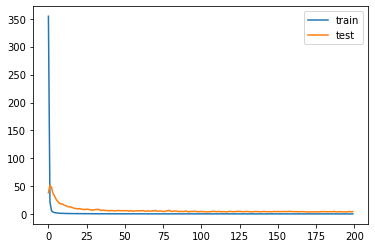

In [30]:
from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

# design network
model = Sequential()
# model.add(BatchNormalization())

# For LSTM
model.add(LSTM(num_inputs, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(num_inputs, input_shape=(train_X.shape[1], train_X.shape[2])))

# For Regular input Dense layers
# model.add(Dense(num_inputs, input_shape=(1, train_X.shape[2])))

# model.add(Dropout(0.3))
# model.add(BatchNormalization())
# for i in range(40):
#     model.add(Dense(30, activation='relu'))

# model.add(Dropout(0.3))
# model.add(BatchNormalization())
model.add(Dense(25, activation='swish'))
# model.add(Dropout(0.3))
# model.add(BatchNormalization())

# For Multiple prediction Dense
# model.add(Dense(train_y.shape[2]))

# For single prediction of LSTM
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
# for i in range(100):
history = model.fit(train_X, train_y, epochs=200, batch_size=512, validation_data=(test_X, test_y), verbose=2, shuffle=True)
#     model.reset_states()
    # plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Model Evaluation

In [31]:
# make a prediction
yhat = model.predict(test_X)
# yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))
yhat = yhat.reshape((yhat.shape[0], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
print(test_X.shape)
print(yhat.shape)
print(test_y.shape)
inv_yhat = concatenate((test_X, yhat), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = test_scaler[0].inverse_transform(inv_yhat)
# invert scaling for actual
test_y = test_y.reshape((len(test_y), num_outputs))
# test_y = test_y.reshape((len(test_y), 4))
inv_y = concatenate((test_X, test_y), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = test_scaler[0].inverse_transform(inv_y)

# calculate RMSE
for i in range(num_inputs, num_inputs+num_outputs):
# for i in range(num_inputs, num_inputs+1):
    rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    print('Test RMSE: %.3f' % rmse)
    mae = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    print('Test MAE: %.3f' % mae)

(16625, 80)
(16625, 1)
(16625, 1)
Test RMSE: 2.173
Test MAE: 1.737


### Results
#### Train Test Data Split randomly
With Hidden Inner Layer with 25 neurons, activation = relu, loss='mae', scaled data, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 1.994  
Test MAE: 1.410  
Test RMSE: 2.598  
Test MAE: 1.816  
Test RMSE: 3.011  
Test MAE: 2.058  

With Hidden Inner Layer with 25 neurons, activation = relu, loss='mean_squared_error', scaled data, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 2.028  
Test MAE: 1.435  
Test RMSE: 2.571  
Test MAE: 1.806  
Test RMSE: 2.924  
Test MAE: 2.082  

With Hidden Inner Layer with 25 neurons, activation = swish, loss='mean_squared_error', scaled data, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles 
Test RMSE: 2.016  
Test MAE: 1.421  
Test RMSE: 2.624  
Test MAE: 1.834  
Test RMSE: 3.063  
Test MAE: 2.151  

#### Test Train Data Split Up to Last Person (Sam Sites)
With Hidden Inner Layer with 25 neurons, activation = swish, loss='mean_squared_error', scaled data, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles 
Test RMSE: 6.888  
Test MAE: 5.696  
Test RMSE: 9.441  
Test MAE: 8.059  
Test RMSE: 11.710  
Test MAE: 10.333  

With Hidden Inner Layer with 25 neurons, activation = relu, loss='mean_squared_error', scaled data, batch=72, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 10.138  
Test MAE: 8.945  
Test RMSE: 11.869  
Test MAE: 10.049  
Test RMSE: 13.293  
Test MAE: 11.266  

With Hidden Inner Layer with 25 neurons, activation = relu, loss='mean_squared_error', scaled data, batch=144, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 6.039
Test MAE: 5.116
Test RMSE: 7.483
Test MAE: 6.294
Test RMSE: 10.444
Test MAE: 8.451

With Hidden Inner Layer with 25 neurons, activation = swish, loss='mean_squared_error', scaled data, batch=144, Shuffle=False, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 8.199  
Test MAE: 7.136  
Test RMSE: 10.291  
Test MAE: 8.630  
Test RMSE: 12.340  
Test MAE: 10.175  

With Hidden Inner Layer with 25 neurons, activation = relu, loss='mean_squared_error', scaled data, batch=144, shuffle=True, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 3.181
Test MAE: 2.592
Test RMSE: 5.544
Test MAE: 4.516
Test RMSE: 6.759
Test MAE: 5.522

With Hidden Inner Layer with 25 neurons, activation = swish, loss='mean_squared_error', scaled data, batch=144, shuffle=True, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 3.908  
Test MAE: 3.055  
Test RMSE: 6.584  
Test MAE: 5.296  
Test RMSE: 9.247  
Test MAE: 7.864  

With Hidden Inner Layer with 25 neurons, activation = relu, loss='mae', scaled data, batch=144, shuffle=True, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 3.807  
Test MAE: 3.059  
Test RMSE: 6.058  
Test MAE: 4.812  
Test RMSE: 8.032  
Test MAE: 6.357  

With Hidden Inner Layer with 25 neurons, activation = relu, loss='mean_squared_error', scaled data, batch=144, shuffle=True, added Normalization and Dropout=0.3, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 3.894
Test MAE: 3.194
Test RMSE: 5.357
Test MAE: 4.506
Test RMSE: 7.164
Test MAE: 5.903

With Hidden Inner Layer with 25 neurons, activation = swish, loss='mean_squared_error', scaled data, batch=144, shuffle=True, added Normalization and Dropout=0.3, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 4.540
Test MAE: 3.910
Test RMSE: 6.023
Test MAE: 5.128
Test RMSE: 8.465
Test MAE: 7.191

With 2 Hidden Inner Layers with 25 neurons, activation = relu, loss='mean_squared_error', scaled data, batch=144, shuffle=True, added Normalization and Dropout=0.3, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 6.378
Test MAE: 5.629
Test RMSE: 7.147
Test MAE: 6.161
Test RMSE: 8.623
Test MAE: 7.372

loss='mean_squared_error', scaled data, batch=144, shuffle=True, added Normalization and Dropout=0.3, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 4.412
Test MAE: 3.776
Test RMSE: 6.409
Test MAE: 5.480
Test RMSE: 8.680
Test MAE: 7.300

loss='mean_squared_error', scaled data, batch=144, shuffle=True, added Dropout=0.3, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 3.365
Test MAE: 2.675
Test RMSE: 5.452
Test MAE: 4.232
Test RMSE: 8.044
Test MAE: 6.605

With Hidden Inner Layer with 25 neurons, activation = swish, loss='mean_squared_error', scaled data, batch=144, shuffle=True, added Dropout=0.3 ONLY BEFORE hidden layter, uses current knee angle and three previous knee angles for inputs -- predicts next three knee angles  
Test RMSE: 3.285
Test MAE: 2.584
Test RMSE: 4.791
Test MAE: 4.089
Test RMSE: 6.863
Test MAE: 5.877

# Convert Model to C++ Code
## Converting LSTM RNN Model

In [ ]:
import requests
import tensorflow.keras as keras
import tensorflow as tf
import sklearn.model_selection
import logging
import numpy as np
import hexdump

keras_model_dir = os.getcwd() + "\\keras_models\\"
filename_wo_dir = 'lstm_knee_angle'
filename = keras_model_dir + filename_wo_dir

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

def rep_data_gen():
    for val in test_X:
        yield [np.array(val, dtype=np.float32, ndmin=2)]
        
converter.representative_dataset = rep_data_gen

tflite_model = converter.convert()
open(filename + '.tflite', 'wb').write(tflite_model)

In [ ]:
# for testing if operations are implemented by Tensorflow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()
interpreter.invoke()

In [ ]:
keras_model_dir = os.getcwd() + "\\keras_models\\"
filename_wo_dir = 'lstm_knee_angle'
filename = keras_model_dir + filename_wo_dir

def hex_to_c_array(hex_data, var_name):
    c_str = ''
    
    # Create Header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n'
    
    # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'
    
    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):
        # Construct string from hex
        hex_str = format(val, '#04x')
        
        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)
        
    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'
    
    # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'
    
    return c_str

with open(filename + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, filename_wo_dir))

In [ ]:
from tinymlgen import port

c_code = port(model, optimize=False, pretty_print=True)

print(len(c_code))

In [ ]:
keras_model_dir = os.getcwd() + "\\keras_models\\"
filename_wo_dir = 'lstm_knee_angle'
filename = keras_model_dir + filename_wo_dir

c_file = open(filename + '.h', 'w+')

n = c_file.write(c_code)
c_file.close()

In [ ]:
import math
import numpy as np
from sklearn.datasets import load_digits
import tensorflow as tf
from tensorflow.keras import layers
from tinymlgen import port


def get_data():
    np.random.seed(1337)
    x_values, y_values = load_digits(return_X_y=True)
    x_values /= x_values.max()
    # reshape to (8 x 8 x 1)
    x_values = x_values.reshape((len(x_values), 8, 8, 1))

    # split into train, validation, test
    TRAIN_SPLIT = int(0.6 * len(x_values))
    TEST_SPLIT = int(0.2 * len(x_values) + TRAIN_SPLIT)
    x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
    y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

    return x_train, x_test, x_validate, y_train, y_test, y_validate

def get_model():
    x_train, x_test, x_validate, y_train, y_test, y_validate = get_data()

    # create a CNN
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(8, 8, 1)))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    # model.add(layers.MaxPooling2D((2, 2)))
    # model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    # model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(len(np.unique(y_train))))

    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=50, batch_size=16,
              validation_data=(x_validate, y_validate))
    return model, x_test, y_test


def test_model(model, x_test, y_test):
    x_test = (x_test / x_test.max()).reshape((len(x_test), 8, 8, 1))
    y_pred = model.predict(x_test).argmax(axis=1)
    print('ACCURACY', (y_pred == y_test).sum() / len(y_test))
    exit()


# if __name__ == '__main__':
model, x_test, y_test = get_model()
test_model(model, x_test, y_test)
c_code = port(model, optimize=False, variable_name='digits_model', pretty_print=True)
print(c_code)
# keras_model_dir = os.getcwd() + "\\keras_models\\"
# filename_wo_dir = 'lstm_knee_angle'
# filename = keras_model_dir + filename_wo_dir

# c_file = open(filename + '.h', 'w+')

# n = c_file.write(c_code)
# c_file.close()

In [ ]:
import tinymlgen as tmg

print(tmg.__version__)